In [1]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from PIL import Image, ExifTags

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, accuracy_score
import scipy

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback

#salmon-scales
#from train_util import read_images, load_xy, get_checkpoint_tensorboard, create_model_grayscale, get_fresh_weights, base_output, dense1_linear_output, train_validate_test_split


In [3]:
!pip install plotly --user
!pip install torch --user
!pip install loguru --user
!pip install timm --user #PyTorch Image Models
!pip install albumentations  --user #augmentation
!pip install colorama --user #color terminal

In [17]:
import os
import gc
import copy
import time
import random

import numpy as np
import pandas as pd
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

from tqdm import tqdm
from collections import defaultdict

from loguru import logger

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore
b_ = Fore.BLUE

from train_val_test_split import train_validate_test_split

### Train Configuration

In [13]:
# Source: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# tf_efficientnetv2_s_in21k - input_size=(3, 300, 300), test_input_size=(3, 384, 384)
# tf_efficientnetv2_m_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_l_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_xl_in21k -input_size=(3, 384, 384), test_input_size=(3, 512, 512)

class CONFIG:
    seed = 42
    model_name = 'tf_efficientnetv2_xl_in21k' 
    train_batch_size = 8
    valid_batch_size = 8
    img_size = 384
    val_img_size = 480
    epochs = 25
    learning_rate = 1e-5
    min_lr = 1e-6
    weight_decay = 1e-6
    T_max = 10
    scheduler = 'CosineAnnealingLR'
    n_accumulate = 1
    n_fold = 5
    target_size = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    debugging = False
    which_exposure = "min"
    CHANNELS = "channels_first"
    
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)    

### Read files to Pandas

In [15]:
def read_jpg_cods(config):
    """
    reads a .jpg file in each folder in structure of folders
    depending on light exposure in {min, middle, max}
    returns tensor with images, and 1-1 correspondence with age
    """
    df_cod = pd.DataFrame(columns=['age', 'image', 'path', 'light', 'ExposureTime'])

    base_dir = '/gpfs/gpfs0/deep/data/Savannah_Professional_Practice2021_06_10_21/CodOtholiths-MachineLearning/Savannah_Professional_Practice'
    base_dirs_posix = Path(base_dir)

    error_count = 0
    add_count = 0
    for some_year_dir in base_dirs_posix.iterdir():
        if config.debugging: # terminate quickly for testing
            if add_count > 0:
                break

        if not os.path.isdir(some_year_dir) or "Extra" in str(some_year_dir): #dont read files in root dir, or folder "Extra"
            continue

        # dir structure: /year/station_number/cod_img_by_age/6 jpeg images of one fish
        stat_nos = [name for name in os.listdir(some_year_dir) if os.path.isdir(os.path.join(some_year_dir, name))]
        for i in range(0, len(stat_nos)):
            cod_path = os.path.join(some_year_dir, stat_nos[i])
            yr_station_codage_path = [os.path.join(cod_path, n) for n in os.listdir(cod_path)
                                      if os.path.isdir(os.path.join(cod_path, n))]
            cod_age = [n for n in os.listdir(cod_path)
                       if os.path.isdir(os.path.join(cod_path, n))]

            assert len(yr_station_codage_path) == len(cod_age)
            for j in range(0, len(yr_station_codage_path)):
                # print(onlyfiles)
                onlyfiles = [f for f in os.listdir(yr_station_codage_path[j])
                             if os.path.isfile(os.path.join(yr_station_codage_path[j], f))]

                if len(onlyfiles) != 6:
                    # print(str(len(onlyfiles)) + '\t' + str( yr_station_codage_path[j] ) + "\t" +'\t'.join(map(str,onlyfiles)))
                    error_count += 1
                else:
                    full_path = [os.path.join(yr_station_codage_path[j], f)
                                 for f in os.listdir(yr_station_codage_path[j])
                                 if os.path.isfile(os.path.join(yr_station_codage_path[j], f))]

                    begin_age = cod_age[j].lower().find('age')
                    age = cod_age[j][begin_age + 3:begin_age + 5]
                    try:
                        age = int(age)
                    except ValueError:
                        age = 0
                        continue

                    full_path.sort()
                    exposures_set = set()
                    exposures_list = []
                    for k in range(0, len(full_path)):
                        img = Image.open(full_path[k])
                        exif = {ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS}
                        exposures_set.add(exif['ExposureTime'])  # requires: 3 unique exposures,
                        exposures_list.append(exif['ExposureTime'])  # requires: 6 exposures total - rotated 180 deg

                    if len(exposures_list) == 6 and len(exposures_set) == 3 and age not in [0, 14, 15, 16, 17]:
                        expo_args = np.argsort(exposures_list).tolist()

                        # print( "exposures_list"+str(exposures_list) )
                        # print(" argsort: "+str(expo_args) )
                        # if expo_args != [1, 4, 0, 3, 2, 5]:
                        # print( "exposures_list"+str(exposures_list) )
                        # print(" argsort: "+str(expo_args) )

                        index_to_exposed_jpg = -1
                        light_value = -1
                        if config.which_exposure == 'min':
                            index_to_exposed_jpg = 0
                            light_value = 1
                        if config.which_exposure == 'middle':
                            index_to_exposed_jpg = 2
                            light_value = 2

                        if config.which_exposure == 'max':
                            index_to_exposed_jpg = 4
                            light_value = 3

                        pil_img = load_img(full_path[expo_args[ index_to_exposed_jpg ]], target_size=(config.img_size, config.img_size))
                        array_img = img_to_array(pil_img, data_format=config.CHANNELS)
                        add_count += 1
                        #print("fp:"+str(full_path[expo_args[ index_to_exposed_jpg ]]) )
                        df_cod = df_cod.append({
                            'age': age,
                            'image': array_img,
                            'path': full_path[expo_args[ index_to_exposed_jpg ]],
                            'light': light_value,
                            'ExposureTime': exposures_list[expo_args[ index_to_exposed_jpg ]]}, ignore_index=True)

    print("error_count:" + str(error_count))
    print("add_count:" + str(add_count))
    return df_cod

### Read dataset

In [16]:
B4_input_shape = (3, CONFIG.img_size, CONFIG.img_size)  

df = read_jpg_cods( CONFIG ) #5316 #5110
# 5110 images, after updating folder 2015: len age:5153

print("len age:"+str( len(df.age) ) ) #len age:5090, error_count:205

error_count:222
add_count:5153
len age:5153


### Test data

In [8]:
#df.age[5089]

tmp = np.asarray( df.image )
a = np.stack(tmp, axis=0).shape #(5090, 3, 300, 300)
print(a)

print("len age:"+str( len(df.age) ) ) #len age:5090

(5090, 3, 300, 300)
len age:5090


### Test Dataset class

In [9]:
pil_img = load_img(df.path[0], target_size=(300,300), grayscale=False)
array_img = img_to_array(pil_img, data_format='channels_first')
image = array_img

print(B4_input_shape)
#image = np.load(df.path[0],allow_pickle=True).astype(np.float32)
print(image.shape)
image = (image - image.mean(axis=(1,2), keepdims=True)) / image.std(axis=(1,2), keepdims=True)
print(image.shape)
#image = np.vstack(image).transpose((1, 0))
print(image.shape)
label = torch.tensor(df.age[0]).float()
print(image.shape) #(3, 144400)
print(label)

(3, 384, 384)
(3, 300, 300)
(3, 300, 300)
(3, 300, 300)
(3, 300, 300)
tensor(1.)


### Dataset class

In [13]:
class codDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['path'].values
        self.labels = df['age'].values
        self.image = np.stack( df['image'].values , axis=0) # make 4D-array (num_imgs, channels, width,height)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #print("loading filename:"+str(self.file_names[index]))
        #image = np.load(self.file_names[index]).astype(np.float32)
        #B4_input_shape = (380, 380, 3)
        #pil_img = load_img(df.path[0], target_size=B4_input_shape, grayscale=False)
        #image = img_to_array(pil_img, data_format='channels_last')
        
        image = self.df.image[index] * 1.0/255.0
        #image = (image - image.mean( axis=(1,2), keepdims=True )) / image.std(axis=(1,2), keepdims=True)
        label = torch.tensor(self.labels[index]).float()
        
        #if self.transforms:
        #image = self.transforms(image=image)["image"]
            
        return image, label

### Test standardscalar

In [9]:
from sklearn.preprocessing import StandardScaler
age = np.asarray([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])

train_age = []
test_age = [] #<class 'list'>
for i in range(0, len(age)):
    train_age.append(age[i])
    test_age.append(age[i])

train_age = np.asarray(train_age)

#kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
#for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_age)):

kfold = StratifiedKFold(n_splits = 5)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_age, train_age)):
    train_idx = trn_ind
    val_idx = val_ind

    unique, counts = np.unique( train_age[train_idx], return_counts=True)
    print( dict(zip(unique, counts)) )
    
    scaler = StandardScaler()
    #train_age = np.asarray( train_age ).reshape(-1,1)  #(30,1) without reshape (30,)
    scaler.fit( train_age.reshape(-1,1) )
    train_age = scaler.transform( train_age.reshape(-1,1) ).squeeze()
    print(train_age.shape)

    test_age = np.asarray( test_age ).reshape(-1,1) 
    test_age = scaler.transform( test_age )
    print(test_age.squeeze())

    test_age = np.vstack(test_age)
    age = np.vstack(age)

"""
    print("min/max train_age:"+str(np.min(np.asarray(train_age)))+ ", "+ str(np.max(np.asarray(train_age))) )
    print("min/max test_age:"+str(np.min(np.asarray(test_age)))+ ", "+ str(np.max(np.asarray(test_age))) )
    print("train_age shape:"+str(train_age.shape))
    print("test_age shape:"+str(test_age.shape))
    print("age.shape:"+str(age.shape))

"""
    

{1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4}
(30,)
[-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
{-1.4638501094227998: 4, -0.8783100656536799: 4, -0.29277002188455997: 4, 0.29277002188455997: 4, 0.8783100656536799: 4, 1.4638501094227998: 4}
(30,)
[-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011
 -1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
{-1.4638501094227998: 4, -0.8783100656536799: 4, -0.29277002188455997: 4, 0

'\n    print("min/max train_age:"+str(np.min(np.asarray(train_age)))+ ", "+ str(np.max(np.asarray(train_age))) )\n    print("min/max test_age:"+str(np.min(np.asarray(test_age)))+ ", "+ str(np.max(np.asarray(test_age))) )\n    print("train_age shape:"+str(train_age.shape))\n    print("test_age shape:"+str(test_age.shape))\n    print("age.shape:"+str(age.shape))\n\n'

### Augmentation

In [14]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG.img_size, CONFIG.img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=360, 
                           p=0.5),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG.img_size, CONFIG.img_size),
        ToTensorV2()], p=1.)
}

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning:

This class has been deprecated. Please use CoarseDropout



### Cod Model

In [15]:
class codModel(nn.Module):

    def __init__(self, model_name, pretrained=True):
        super(codModel, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_l_in21k', pretrained=pretrained, in_chans=3, num_classes=1) #model_name
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, CONFIG.target_size)
        #lastLayer = nn.Sequential(nn.Linear(self.n_features, 256),
        #      nn.LeakyReLU(),
        #      nn.Linear(256, 32),
        #      nn.LeakyReLU(),
        #      nn.Linear(32, CONFIG.target_size))
        #self.model.classifier = lastLayer
        #print("model self:"+str(self.model.classifier))

    def forward(self, x):
        output = self.model(x)
        return output
    
model = codModel(CONFIG.model_name)
model.to(CONFIG.device);

### debug output - linear layer

In [12]:
model = timm.create_model(CONFIG.model_name, pretrained=True, in_chans=3)
#n_features = model.classifier.in_features
model.classifier

Linear(in_features=1280, out_features=21843, bias=True)

tensor([[0.2254]], grad_fn=<AddmmBackward0>)
tensor(113.8671, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 0, loss 113.86708068847656
tensor(9.3376, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 1, loss 9.337577819824219
tensor(0.8109, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 2, loss 0.8108803629875183
tensor(0.1148, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 3, loss 0.1148345097899437
tensor(0.0575, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 4, loss 0.05751663073897362
tensor(0.0523, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 5, loss 0.052303723990917206
tensor(0.0513, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 6, loss 0.05134684965014458
tensor(0.0507, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 7, loss 0.05074301362037659
tensor(0.0502, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 8, loss 0.05017391964793205
tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 9, loss 0.04961342364549637
tensor(0.0491, de

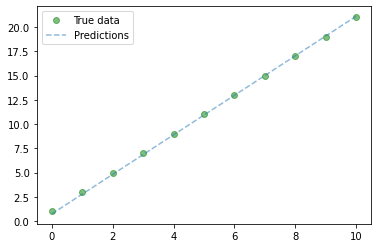

In [318]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

m = nn.Linear(128, 1) 
input = torch.randn(1, 128 ) 
output = m(input)
print(output)
################
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out
    
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()
    
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    print(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()    

In [16]:
#!pip install torchsummary
from torchsummary import summary

summary(model, (3, 384,384))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 192, 192]             864
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              SiLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 32, 192, 192]           9,216
       BatchNorm2d-5         [-1, 32, 192, 192]              64
              SiLU-6         [-1, 32, 192, 192]               0
         ConvBnAct-7         [-1, 32, 192, 192]               0
            Conv2d-8         [-1, 32, 192, 192]           9,216
       BatchNorm2d-9         [-1, 32, 192, 192]              64
             SiLU-10         [-1, 32, 192, 192]               0
        ConvBnAct-11         [-1, 32, 192, 192]               0
           Conv2d-12         [-1, 32, 192, 192]           9,216
      BatchNorm2d-13         [-1, 32, 192, 192]              64
             SiLU-14         [-1, 32, 1

          Conv2d-936            [-1, 160, 1, 1]         614,560
            SiLU-937            [-1, 160, 1, 1]               0
          Conv2d-938           [-1, 3840, 1, 1]         618,240
         Sigmoid-939           [-1, 3840, 1, 1]               0
   SqueezeExcite-940         [-1, 3840, 12, 12]               0
          Conv2d-941          [-1, 640, 12, 12]       2,457,600
     BatchNorm2d-942          [-1, 640, 12, 12]           1,280
InvertedResidual-943          [-1, 640, 12, 12]               0
          Conv2d-944         [-1, 3840, 12, 12]       2,457,600
     BatchNorm2d-945         [-1, 3840, 12, 12]           7,680
            SiLU-946         [-1, 3840, 12, 12]               0
          Conv2d-947         [-1, 3840, 12, 12]          34,560
     BatchNorm2d-948         [-1, 3840, 12, 12]           7,680
            SiLU-949         [-1, 3840, 12, 12]               0
          Conv2d-950            [-1, 160, 1, 1]         614,560
            SiLU-951            [-1, 160

In [62]:
model.eval()

codModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(24, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNorm2d(96, eps=0

In [87]:
x     = torch.rand((8, 3, 300, 300))
labels = torch.from_numpy( np.asarray([1,2,3,4,5,6,7,8]) )
print(torch.cuda.is_available())
print(labels)
                      
inputs, labels = x.to(CONFIG.device), labels.to(CONFIG.device)
print(labels)
model.to(CONFIG.device);

model(inputs).shape

True
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


torch.Size([8, 1])

### Kfolds

In [16]:
#df = pd.read_csv(f"{ROOT_DIR}/train_labels.csv")
skf = StratifiedKFold(n_splits=CONFIG.n_fold, shuffle=True, random_state=CONFIG.seed)
y_train = df.age.values

for fold, ( train_idx, val_idx) in enumerate( skf.split( X=df, y=df.age.values.tolist() ) ):
    df.loc[val_idx , "kfold"] = int(fold)
    unique, counts = np.unique(df.age.values, return_counts=True)
    print( dict(zip(unique, counts)) )

unique, counts = np.unique(df.age.values, return_counts=True)
print( dict(zip(unique, counts)) )
df['kfold'] = df['kfold'].astype(int)
print(df.kfold)

{1: 382, 2: 522, 3: 509, 4: 624, 5: 806, 6: 540, 7: 546, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
{1: 382, 2: 522, 3: 509, 4: 624, 5: 806, 6: 540, 7: 546, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
{1: 382, 2: 522, 3: 509, 4: 624, 5: 806, 6: 540, 7: 546, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
{1: 382, 2: 522, 3: 509, 4: 624, 5: 806, 6: 540, 7: 546, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
{1: 382, 2: 522, 3: 509, 4: 624, 5: 806, 6: 540, 7: 546, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
{1: 382, 2: 522, 3: 509, 4: 624, 5: 806, 6: 540, 7: 546, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
0       3
1       3
2       4
3       1
4       4
       ..
5148    0
5149    0
5150    4
5151    3
5152    4
Name: kfold, Length: 5153, dtype: int64


### Prepare data

In [17]:
def prepare_data(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = codDataset(df_train, transforms=data_transforms['train'])
    valid_dataset = codDataset(df_valid, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

### Prepare dataloader

In [18]:
train_loader, valid_loader = prepare_data(fold=0)
print(train_loader)
inputs, classes = next(iter(train_loader))  
print(inputs.shape)

fold=0
train_dataset=None
df_train = df[df.kfold != fold].reset_index(drop=True)
print("df_train.shape"+str( df_train.shape ))
train_dataset_tmp = codDataset(df_train, transforms=data_transforms['train'])

print("train_dataset_tmp:"+str(train_dataset_tmp[0][0].shape))
tmp_loader = DataLoader(train_dataset_tmp, batch_size=1) #, batch_size=CONFIG.train_batch_size, 
                          #num_workers=0, shuffle=True, pin_memory=True)
    
print("batch1 :"+str(train_dataset_tmp[0][0].shape))

inputs, classes = next(iter(tmp_loader))  
print("dadf1:"+str(inputs.shape))


torch.Size([8, 3, 384, 384])
df_train.shape(4122, 6)
train_dataset_tmp:(3, 384, 384)
batch1 :(3, 384, 384)
dadf1:torch.Size([1, 3, 384, 384])


### Loss function

In [16]:
#def binary_accuracy_for_regression(y_true, y_pred):
#    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

loss = nn.MSELoss()
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

### Training function

In [19]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    
    loss_fn = nn.MSELoss()
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar:  
        #optimizer.zero_grad()
        
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        labels = torch.unsqueeze(labels, 1)
        
        batch_size = images.size(0)
        
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            #print("outputs:+"+str(outputs))
            #print("labels:"+str(labels))
            #print("mse:"+str(mean_squared_error(labels.cpu().data.numpy(), outputs.cpu().data.numpy())))
            loss = loss_fn(outputs, labels)
         
        #loss.backward()
        #optimizer.step()
        
        scaler.scale(loss).backward() # Scales loss.  Calls backward() on scaled loss to create scaled gradients
        #model.print_debug() #model.classifier.weight[0:10,0]
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        
        scaler.step(optimizer)
        scaler.update() # Updates the scale for next iteration.
            
        # zero the parameter gradients
        optimizer.zero_grad() # set_to_none=True here can modestly improve performance
                
        running_loss += loss.item() #(loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

### Test train function

In [40]:
def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

#for name, param in model.named_parameters():
#for param in model.parameters():
#    print(str( name ) +" "+ str(param.requires_grad))
 

gc.collect()
train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

cuda:0
25


100%|██████████| 509/509 [01:52<00:00,  4.54it/s, Epoch=0, LR=0.001, Train_Loss=0.0219]


In [15]:
#model, optimizer, scheduler, device, num_epochs

def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)

print( model )
print( optimizer )
print( scheduler )
print( train_loader )
print( epoch )
#model, history = run(model, optimizer, scheduler=scheduler, device=CONFIG.device, num_epochs=CONFIG.epochs)
#############

#train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
#                       dataloader=train_loader, 
#                       device=CONFIG.device, epoch=epoch)

codModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
        )
        (1): ConvBnAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
        )
        (2): ConvBnAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine

NameError: name 'epoch' is not defined

### Validation function

In [20]:
from sklearn.metrics import accuracy_score, mean_squared_error

@torch.no_grad()
def valid_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar: 
        #print("images:"+str(images.shape))
        #print("labels:"+str(labels.shape))
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.unsqueeze(labels, 1)
        #print("labels.shape:"+str(labels.shape))
        
        batch_size = images.size(0)
        #print("batch_size:"+str(batch_size))

        
        outputs = model(images)
        #print("outputs:+"+str(outputs))
        #print("labels:"+str(labels))
        #print("mse:"+str(mean_squared_error(labels.cpu().data.numpy(), outputs.cpu().data.numpy())))
            
        #print("outputs:"+str(outputs.shape))
        #outputs = torch.squeeze(outputs)
        loss = nn.MSELoss()(outputs, labels)
        #loss = criterion(outputs.view(-1), labels)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        PREDS.append(outputs.cpu().detach().numpy())
        TARGETS.append(labels.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    PREDS = np.squeeze(PREDS)
    
    #print(type(PREDS[0]))
    #print(type(TARGETS[0]))
    #print(PREDS.shape)
    #print(TARGETS.shape)
    print("preds:"+str(PREDS[:-10]))
    print("target:"+str(TARGETS[:-10]))
    print("max:"+str(np.max( PREDS )))
    print("mean:"+str(np.mean( PREDS )))
    
    PREDS = PREDS.round()
    val_auc = accuracy_score(TARGETS, PREDS) #roc_auc_score(TARGETS, PREDS)
    mse_score = mean_squared_error(TARGETS, PREDS)
    print(val_auc)
    print(mse_score)
    gc.collect()
    
    return epoch_loss , val_auc

### Test validation

In [50]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

gc.collect()
train_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

cuda:0
25


100%|██████████| 509/509 [00:56<00:00,  9.08it/s, Epoch=0, LR=0.001, Valid_Loss=0.235]

preds:[3.5345225 4.952975  5.3617673 ... 5.6906924 4.212286  3.5432181]
target:[3. 5. 5. ... 6. 4. 4.]
max:13.21456
mean:5.4454145
0.7266699410609038
0.29862475


### Run

In [21]:
@logger.catch
def run(model, optimizer, scheduler, device, num_epochs):    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auc = 0
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG.device, epoch=epoch)
        
        valid_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler,
                                                            dataloader=valid_loader, 
                                                            device=CONFIG.device, epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Valid AUC'].append(acc_score) #valid_epoch_auc)
        
        #print(f'Valid AUC: {valid_epoch_auc}')
        
        if scheduler is not None:
            scheduler.step()
        
        # deep copy the model
        if acc_score >= best_epoch_auc:
            print(f"{b_}Validation AUC Improved ({best_epoch_auc} ---> {acc_score})")
            best_epoch_auc = acc_score
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUC{:.4f}_epoch{:.0f}.bin".format(best_epoch_auc, epoch)
            torch.save(model.state_dict(), PATH)
            print("Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUC: {:.4f}".format(best_epoch_auc))
    
    # load best model weights
    #model.load_state_dict(best_model_wts)
    #print(model.classifier.weight[0:10,0])
    
    return model, history

### Train fold 0

In [179]:
#torch.cuda.is_available() 

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)

print(CONFIG.device)
print(CONFIG.epochs)
model, history = run(model, optimizer, scheduler=scheduler, device=CONFIG.device, num_epochs=250) #CONFIG.epochs)

cuda:0
25


100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=1, LR=1e-5, Valid_Loss=0.388]


preds:[ 5.7540708  3.3989155  7.411528  ...  4.0649805  4.197875  10.304616 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.48343
mean:5.3450212
0.6702230843840931
0.4500485
Validation AUC Improved (0 ---> 0.6702230843840931)
Model Saved



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=2, LR=9.78e-6, Valid_Loss=0.39] 


preds:[ 5.739422   3.3948092  7.350868  ...  4.140256   4.2930045 10.224243 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.357709
mean:5.3426456
0.6702230843840931
0.4471387
Validation AUC Improved (0.6702230843840931 ---> 0.6702230843840931)
Model Saved



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=3, LR=9.14e-6, Valid_Loss=0.388]


preds:[ 5.7920833  3.4171002  7.3116574 ...  4.143195   4.291913  10.316884 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.431038
mean:5.3598304
0.6673132880698351
0.4500485



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=4, LR=8.15e-6, Valid_Loss=0.389]


preds:[ 5.6979475  3.3827474  7.332579  ...  4.1170483  4.28906   10.279778 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.347037
mean:5.3279877
0.6789524733268671
0.4325897
Validation AUC Improved (0.6702230843840931 ---> 0.6789524733268671)
Model Saved



100%|██████████| 129/129 [00:26<00:00,  4.94it/s, Epoch=5, LR=6.89e-6, Valid_Loss=0.386]


preds:[ 5.8005114  3.4315982  7.328986  ...  4.155705   4.3308215 10.299559 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.395465
mean:5.3644896
0.6731328806983511
0.44422892



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=6, LR=5.5e-6, Valid_Loss=0.383]


preds:[ 5.7815013  3.4268467  7.3396187 ...  4.142196   4.366044  10.341423 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.443561
mean:5.372664
0.6702230843840931
0.4413191



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=7, LR=4.11e-6, Valid_Loss=0.398]


preds:[ 5.6386704  3.3503568  7.275329  ...  4.0498962  4.2332797 10.178237 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.298567
mean:5.285789
0.6682832201745877
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=8, LR=2.85e-6, Valid_Loss=0.384]


preds:[ 5.7921867  3.3998098  7.339486  ...  4.126365   4.363111  10.377405 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.421927
mean:5.37039
0.6702230843840931
0.4413191



100%|██████████| 129/129 [00:25<00:00,  4.96it/s, Epoch=9, LR=1.86e-6, Valid_Loss=0.384]


preds:[ 5.804842   3.433349   7.403352  ...  4.158203   4.3948026 10.330835 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.451564
mean:5.382047
0.6750727449078564
0.43937925



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=10, LR=1.22e-6, Valid_Loss=0.387]


preds:[ 5.7078815  3.406668   7.3766294 ...  4.1328864  4.3426814 10.286626 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.378037
mean:5.35807
0.6799224054316197
0.43452957
Validation AUC Improved (0.6789524733268671 ---> 0.6799224054316197)
Model Saved



100%|██████████| 129/129 [00:26<00:00,  4.96it/s, Epoch=11, LR=1e-6, Valid_Loss=0.39] 


preds:[ 5.7252536  3.402988   7.2577333 ...  4.1234503  4.307394  10.300544 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.381261
mean:5.3433003
0.6770126091173618
0.43743938



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=12, LR=1.22e-6, Valid_Loss=0.389]


preds:[ 5.67639    3.3735304  7.320603  ...  4.0817647  4.2976856 10.268105 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.347628
mean:5.3259788
0.6789524733268671
0.43549952



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=13, LR=1.86e-6, Valid_Loss=0.392]


preds:[ 5.717545   3.3853948  7.289568  ...  4.1212373  4.3030066 10.275415 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.333225
mean:5.333383
0.6779825412221144
0.43646944



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=14, LR=2.85e-6, Valid_Loss=0.387]


preds:[ 5.6833444  3.3753643  7.3004875 ...  4.0998755  4.3427935 10.239875 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.315797
mean:5.3238606
0.6750727449078564
0.43937925



100%|██████████| 129/129 [00:25<00:00,  4.97it/s, Epoch=26, LR=5.5e-6, Valid_Loss=0.39] 


preds:[ 5.732145   3.4002771  7.3004336 ...  4.1215177  4.3073606 10.301582 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.422595
mean:5.357899
0.6731328806983511
0.4413191



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=27, LR=4.11e-6, Valid_Loss=0.386]


preds:[ 5.6683598  3.3679855  7.398256  ...  4.1257753  4.331003  10.332233 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.443013
mean:5.3547983
0.6847720659553831
0.42386034
Validation AUC Improved (0.6808923375363725 ---> 0.6847720659553831)
Model Saved



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=28, LR=2.85e-6, Valid_Loss=0.392]


preds:[ 5.6472106  3.343819   7.25678   ...  4.06415    4.296952  10.28902  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.35234
mean:5.3151927
0.6779825412221144
0.44228905



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=29, LR=1.86e-6, Valid_Loss=0.385]


preds:[ 5.751461   3.416831   7.366811  ...  4.1777496  4.3648634 10.364505 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.482877
mean:5.367734
0.6818622696411252
0.42677012



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=30, LR=1.22e-6, Valid_Loss=0.386]


preds:[ 5.6745825  3.3872862  7.379012  ...  4.1363883  4.3340654 10.317172 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.445979
mean:5.3588037
0.6789524733268671
0.42967993



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=31, LR=1e-6, Valid_Loss=0.385]


preds:[ 5.780329   3.3713562  7.3905745 ...  4.1256533  4.352226  10.41288  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.505951
mean:5.3574014
0.6770126091173618
0.43452957



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=32, LR=1.22e-6, Valid_Loss=0.392]


preds:[ 5.688496   3.4053104  7.3093944 ...  4.127195   4.2989    10.281754 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.4160185
mean:5.3468018
0.6750727449078564
0.43646944



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=33, LR=1.86e-6, Valid_Loss=0.386]


preds:[ 5.7339497  3.417321   7.359008  ...  4.185191   4.387826  10.329022 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.441704
mean:5.3690624
0.6799224054316197
0.42870998



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=34, LR=2.85e-6, Valid_Loss=0.391]


preds:[ 5.687224   3.3383603  7.373734  ...  4.0579033  4.2928705 10.302074 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.419638
mean:5.3295536
0.6760426770126091
0.43549952



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=35, LR=4.11e-6, Valid_Loss=0.389]


preds:[ 5.7057652  3.3675659  7.3705034 ...  4.1222324  4.3754854 10.346544 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.456508
mean:5.344878
0.6770126091173618
0.4316198



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=36, LR=5.5e-6, Valid_Loss=0.387]


preds:[ 5.737141   3.4130151  7.306236  ...  4.1362967  4.3451233 10.308706 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.48364
mean:5.3640223
0.6741028128031038
0.43743938



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=37, LR=6.89e-6, Valid_Loss=0.387]


preds:[ 5.7485223  3.4047327  7.363188  ...  4.155101   4.3823743 10.32072  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.471971
mean:5.3534794
0.6741028128031038
0.4316198



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=38, LR=8.15e-6, Valid_Loss=0.388]


preds:[ 5.7867885  3.4505792  7.36723   ...  4.1689706  4.396668  10.327638 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.475318
mean:5.376959
0.6702230843840931
0.4384093



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=39, LR=9.14e-6, Valid_Loss=0.387]


preds:[ 5.7179613  3.3621414  7.4022975 ...  4.131786   4.400406  10.31693  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.4551525
mean:5.3351564
0.6760426770126091
0.4384093



100%|██████████| 129/129 [00:25<00:00,  5.03it/s, Epoch=40, LR=9.78e-6, Valid_Loss=0.39] 


preds:[ 5.6674542  3.3630717  7.320576  ...  4.11427    4.3455005 10.29122  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.474516
mean:5.3340287
0.6770126091173618
0.4316198



100%|██████████| 129/129 [00:25<00:00,  4.97it/s, Epoch=41, LR=1e-5, Valid_Loss=0.393]


preds:[ 5.711307   3.3636408  7.378216  ...  4.1290674  4.331415  10.320533 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.430218
mean:5.3561096
0.6711930164888458
0.44325897



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=42, LR=9.78e-6, Valid_Loss=0.391]


preds:[ 5.7255163  3.4026275  7.3554597 ...  4.1813745  4.3979797 10.314397 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.445083
mean:5.377757
0.6663433559650824
0.45101842



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=43, LR=9.14e-6, Valid_Loss=0.394]


preds:[ 5.663708   3.3669362  7.3097086 ...  4.1012     4.3121014 10.279423 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.400893
mean:5.302216
0.6711930164888458
0.44616878



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=44, LR=8.15e-6, Valid_Loss=0.398]


preds:[ 5.618504   3.3430479  7.309884  ...  4.120005   4.307698  10.304092 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.347497
mean:5.322529
0.6682832201745877
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=45, LR=6.89e-6, Valid_Loss=0.389]


preds:[ 5.720135   3.3817613  7.391586  ...  4.1562014  4.3773923 10.315609 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.446933
mean:5.343185
0.6760426770126091
0.4384093



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=46, LR=5.5e-6, Valid_Loss=0.389]


preds:[ 5.6892543  3.3425941  7.4411216 ...  4.1425     4.396345  10.307385 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.422848
mean:5.3416605
0.6750727449078564
0.43937925



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=47, LR=4.11e-6, Valid_Loss=0.396]


preds:[ 5.7036877  3.3971093  7.4192424 ...  4.203711   4.4362097 10.305718 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.405528
mean:5.365822
0.6692531522793405
0.44810864



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=48, LR=2.85e-6, Valid_Loss=0.39] 


preds:[ 5.691193   3.375066   7.4328017 ...  4.162767   4.4147763 10.280654 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.432398
mean:5.3418093
0.6799224054316197
0.4316198



100%|██████████| 129/129 [00:25<00:00,  4.96it/s, Epoch=49, LR=1.86e-6, Valid_Loss=0.387]


preds:[ 5.708913   3.3878279  7.415676  ...  4.171885   4.427388  10.335408 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.464787
mean:5.350584
0.6741028128031038
0.4316198



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=50, LR=1.22e-6, Valid_Loss=0.398]


preds:[ 5.7000227  3.364379   7.362536  ...  4.1419654  4.396925  10.27615  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.404731
mean:5.333291
0.6653734238603298
0.45198837



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=51, LR=1e-6, Valid_Loss=0.392]


preds:[ 5.661279   3.342726   7.425661  ...  4.1441116  4.4034104 10.293965 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.434725
mean:5.330653
0.6808923375363725
0.43646944



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=52, LR=1.22e-6, Valid_Loss=0.391]


preds:[ 5.696296   3.3935654  7.41037   ...  4.1777406  4.4198675 10.312386 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.469161
mean:5.35478
0.6770126091173618
0.44034916



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=53, LR=1.86e-6, Valid_Loss=0.419]


preds:[ 5.65957    3.3434596  7.3394623 ...  4.101297   4.3640676 10.301101 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.392034
mean:5.342217
0.6605237633365665
0.45974782



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=54, LR=2.85e-6, Valid_Loss=0.393]


preds:[ 5.7295775  3.3552682  7.4104066 ...  4.1568775  4.427939  10.329881 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.4012575
mean:5.3535967
0.6721629485935985
0.44519883



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=55, LR=4.11e-6, Valid_Loss=0.395]


preds:[ 5.6819882  3.3560019  7.3911576 ...  4.1208186  4.3619094 10.263217 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.4176655
mean:5.313293
0.6731328806983511
0.44422892



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=56, LR=5.5e-6, Valid_Loss=0.386]


preds:[ 5.756808  3.382113  7.461086 ...  4.170951  4.442944 10.345708]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.509732
mean:5.3604264
0.6779825412221144
0.42774007



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=57, LR=6.89e-6, Valid_Loss=0.391]


preds:[ 5.769517   3.351615   7.448844  ...  4.1391077  4.387164  10.323402 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.460472
mean:5.3389606
0.6731328806983511
0.4413191



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=58, LR=8.15e-6, Valid_Loss=0.396]


preds:[ 5.6782837  3.3245134  7.402624  ...  4.0838943  4.340304  10.306136 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.430595
mean:5.323228
0.6702230843840931
0.44422892



100%|██████████| 129/129 [00:25<00:00,  4.96it/s, Epoch=59, LR=9.14e-6, Valid_Loss=0.391]


preds:[ 5.702074   3.3524904  7.384734  ...  4.148712   4.40718   10.286736 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.40563
mean:5.3350763
0.6808923375363725
0.43064985



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=60, LR=9.78e-6, Valid_Loss=0.393]


preds:[ 5.733081   3.3656046  7.4617977 ...  4.130547   4.384616  10.282937 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.456488
mean:5.333917
0.6741028128031038
0.44034916



100%|██████████| 129/129 [00:26<00:00,  4.95it/s, Epoch=61, LR=1e-5, Valid_Loss=0.392]


preds:[ 5.682942   3.3822453  7.4223304 ...  4.147717   4.4240904 10.301211 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.496738
mean:5.3406262
0.6750727449078564
0.44228905



100%|██████████| 129/129 [00:25<00:00,  4.98it/s, Epoch=62, LR=9.78e-6, Valid_Loss=0.389]


preds:[ 5.796067   3.3857691  7.3957267 ...  4.155001   4.4556246 10.35747  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.517646
mean:5.354876
0.6750727449078564
0.43937925



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=63, LR=9.14e-6, Valid_Loss=0.395]


preds:[ 5.733392   3.4086075  7.431173  ...  4.1921935  4.436204  10.2983055]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.500763
mean:5.3594584
0.6721629485935985
0.44810864



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=64, LR=8.15e-6, Valid_Loss=0.393]


preds:[ 5.7409725  3.3825734  7.4995747 ...  4.192767   4.428152  10.346868 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.484163
mean:5.3511786
0.6741028128031038
0.44325897



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=65, LR=6.89e-6, Valid_Loss=0.399]


preds:[ 5.7785068  3.4059064  7.395936  ...  4.1663365  4.4033713 10.34149  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.485707
mean:5.346305
0.6673132880698351
0.4500485



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=66, LR=5.5e-6, Valid_Loss=0.393]


preds:[ 5.732347   3.3883078  7.441917  ...  4.1579814  4.419964  10.283798 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.433807
mean:5.338895
0.6702230843840931
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=67, LR=4.11e-6, Valid_Loss=0.392]


preds:[ 5.7409387  3.3530521  7.499901  ...  4.14204    4.432592  10.329131 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.490803
mean:5.347516
0.6760426770126091
0.4413191



100%|██████████| 129/129 [00:25<00:00,  4.96it/s, Epoch=68, LR=2.85e-6, Valid_Loss=0.39] 


preds:[ 5.7887974  3.4141066  7.503492  ...  4.2175665  4.453096  10.37798  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.535517
mean:5.369667
0.6750727449078564
0.43937925



100%|██████████| 129/129 [00:25<00:00,  4.97it/s, Epoch=69, LR=1.86e-6, Valid_Loss=0.397]


preds:[ 5.685049   3.3674648  7.4252076 ...  4.1267877  4.3832936 10.255815 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.430461
mean:5.3220906
0.6692531522793405
0.44810864



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=70, LR=1.22e-6, Valid_Loss=0.392]


preds:[ 5.768049   3.4100013  7.4154572 ...  4.1876545  4.43526   10.3327465]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.484823
mean:5.3487344
0.6711930164888458
0.44325897



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=71, LR=1e-6, Valid_Loss=0.392]


preds:[ 5.739176   3.401116   7.4070897 ...  4.1567664  4.409828  10.31188  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.502056
mean:5.348697
0.6711930164888458
0.44034916



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=72, LR=1.22e-6, Valid_Loss=0.395]


preds:[ 5.6549296  3.3667274  7.3785543 ...  4.151425   4.3862424 10.248174 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.3946905
mean:5.3174167
0.6702230843840931
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=73, LR=1.86e-6, Valid_Loss=0.413]


preds:[ 5.7875557  3.4010236  7.457622  ...  4.1980205  4.436604  10.317677 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.489111
mean:5.3809056
0.6605237633365665
0.4655674



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=74, LR=2.85e-6, Valid_Loss=0.394]


preds:[ 5.696413   3.3575277  7.4328837 ...  4.1449842  4.3816247 10.293353 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.448395
mean:5.325733
0.6682832201745877
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=75, LR=4.11e-6, Valid_Loss=0.393]


preds:[ 5.720771   3.3782518  7.472308  ...  4.1812897  4.4304037 10.319777 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.472248
mean:5.349283
0.6741028128031038
0.44325897



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=76, LR=5.5e-6, Valid_Loss=0.393]


preds:[ 5.7087417  3.3466728  7.4422326 ...  4.110146   4.37302   10.244171 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.422782
mean:5.3278723
0.6711930164888458
0.44616878



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=77, LR=6.89e-6, Valid_Loss=0.39] 


preds:[ 5.7302017  3.3886795  7.4713597 ...  4.1964297  4.460696  10.337655 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.514495
mean:5.374937
0.6673132880698351
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=78, LR=8.15e-6, Valid_Loss=0.391]


preds:[ 5.7382293  3.3844748  7.4754844 ...  4.176431   4.433811  10.327348 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.506475
mean:5.3449817
0.6702230843840931
0.4413191



100%|██████████| 129/129 [00:25<00:00,  5.03it/s, Epoch=79, LR=9.14e-6, Valid_Loss=0.392]


preds:[ 5.719325   3.3540347  7.4699554 ...  4.161598   4.451719  10.341015 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.512976
mean:5.3393
0.6711930164888458
0.44616878



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=80, LR=9.78e-6, Valid_Loss=0.404]


preds:[ 5.6682863  3.3465307  7.387752  ...  4.132871   4.423545  10.25709  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.389473
mean:5.3325634
0.6653734238603298
0.45198837



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=81, LR=1e-5, Valid_Loss=0.397]


preds:[ 5.7515745  3.3708234  7.4999995 ...  4.207657   4.4648995 10.354949 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.509066
mean:5.368387
0.6653734238603298
0.45489815



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=82, LR=9.78e-6, Valid_Loss=0.394]


preds:[ 5.707682   3.342194   7.483578  ...  4.1808743  4.4519763 10.305635 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.482786
mean:5.3391523
0.6750727449078564
0.44228905



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=83, LR=9.14e-6, Valid_Loss=0.389]


preds:[ 5.761592   3.3698761  7.062002  ...  4.1544733  4.5120583 10.34617  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.578497
mean:5.3665338
0.6692531522793405
0.43646944



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=84, LR=8.15e-6, Valid_Loss=0.394]


preds:[ 5.7330933  3.376659   7.45919   ...  4.180612   4.480153  10.374818 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.56734
mean:5.3663993
0.6682832201745877
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=85, LR=6.89e-6, Valid_Loss=0.395]


preds:[ 5.78587    3.4030066  7.509531  ...  4.203886   4.4639444 10.325023 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.562676
mean:5.373638
0.6595538312318138
0.45780796



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=86, LR=5.5e-6, Valid_Loss=0.415]


preds:[ 5.7175207  3.3649127  7.4371624 ...  4.141861   4.4022555 10.296034 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.479993
mean:5.339906
0.6566440349175557
0.46362755



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=87, LR=4.11e-6, Valid_Loss=0.392]


preds:[ 5.7485433  3.371875   7.520027  ...  4.194331   4.481421  10.341824 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.558741
mean:5.359517
0.6750727449078564
0.44228905



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=88, LR=2.85e-6, Valid_Loss=0.393]


preds:[ 5.7003107  3.3964658  7.40212   ...  4.200397   4.4486036 10.334604 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.548614
mean:5.3432136
0.6721629485935985
0.44228905



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=89, LR=1.86e-6, Valid_Loss=0.393]


preds:[ 5.7273164  3.3821764  7.484692  ...  4.1656327  4.4454827 10.34231  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.576815
mean:5.34392
0.6673132880698351
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=90, LR=1.22e-6, Valid_Loss=0.398]


preds:[ 5.765953  3.373609  7.464744 ...  4.199561  4.482427 10.34261 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.515152
mean:5.3521914
0.6634335596508244
0.45101842



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=91, LR=1e-6, Valid_Loss=0.395]


preds:[ 5.7122974  3.3766909  7.442909  ...  4.181394   4.438657  10.296327 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.47899
mean:5.334331
0.6682832201745877
0.44907856



100%|██████████| 129/129 [00:25<00:00,  4.99it/s, Epoch=92, LR=1.22e-6, Valid_Loss=0.394]


preds:[ 5.7240815  3.3882973  7.48689   ...  4.188144   4.4385943 10.295675 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.540273
mean:5.343056
0.6702230843840931
0.44422892



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=93, LR=1.86e-6, Valid_Loss=0.393]


preds:[ 5.7459764  3.39586    7.505362  ...  4.162176   4.4388695 10.287685 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.561586
mean:5.352092
0.6682832201745877
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=94, LR=2.85e-6, Valid_Loss=0.394]


preds:[ 5.77159    3.3974996  7.507173  ...  4.2034993  4.489607  10.300563 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.548197
mean:5.3625555
0.6663433559650824
0.45101842



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=95, LR=4.11e-6, Valid_Loss=0.397]


preds:[ 5.701624   3.3657546  7.470765  ...  4.181021   4.437619  10.301575 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.548764
mean:5.3422956
0.6653734238603298
0.45198837



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=96, LR=5.5e-6, Valid_Loss=0.396]


preds:[ 5.721244   3.3860102  7.430711  ...  4.200799   4.452023  10.255366 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.527893
mean:5.339107
0.6702230843840931
0.44422892



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=97, LR=6.89e-6, Valid_Loss=0.394]


preds:[ 5.758894   3.389884   7.4734507 ...  4.1921453  4.4448833 10.290494 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.554975
mean:5.3517275
0.6692531522793405
0.45101842



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=98, LR=8.15e-6, Valid_Loss=0.399]


preds:[ 5.7418547  3.414899   7.462504  ...  4.2192793  4.456502  10.260063 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.515228
mean:5.360142
0.6653734238603298
0.45198837



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=99, LR=9.14e-6, Valid_Loss=0.399]


preds:[ 5.79928    3.3664176  7.4383245 ...  4.193878   4.4837666 10.354964 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.602887
mean:5.359428
0.6644034917555771
0.4529583



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=100, LR=9.78e-6, Valid_Loss=0.4]  


preds:[ 5.73662    3.3609703  7.40722   ...  4.167415   4.4075117 10.295842 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.546927
mean:5.310137
0.6711930164888458
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=101, LR=1e-5, Valid_Loss=0.393]


preds:[ 5.8121967  3.375361   7.505739  ...  4.2170286  4.5180025 10.365891 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.581574
mean:5.3756924
0.6673132880698351
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=102, LR=9.78e-6, Valid_Loss=0.404]


preds:[ 5.758847   3.3695915  7.461147  ...  4.208966   4.491046  10.262712 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.459235
mean:5.3309965
0.6634335596508244
0.456838



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=103, LR=9.14e-6, Valid_Loss=0.395]


preds:[ 5.7335806  3.3463633  7.473483  ...  4.1577034  4.4511566 10.297673 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.464721
mean:5.3381286
0.6702230843840931
0.4471387



100%|██████████| 129/129 [00:26<00:00,  4.94it/s, Epoch=104, LR=8.15e-6, Valid_Loss=0.394]


preds:[ 5.7938704  3.3778503  7.4980392 ...  4.1785197  4.4756694 10.282467 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.527103
mean:5.3527217
0.6673132880698351
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=105, LR=6.89e-6, Valid_Loss=0.392]


preds:[ 5.815102   3.4089382  7.5225363 ...  4.2137384  4.490324  10.309243 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.550427
mean:5.3651257
0.6682832201745877
0.45198837



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=106, LR=5.5e-6, Valid_Loss=0.396]


preds:[ 5.7494774  3.3570156  7.525851  ...  4.165427   4.45801   10.286763 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.525531
mean:5.348626
0.6711930164888458
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=107, LR=4.11e-6, Valid_Loss=0.394]


preds:[ 5.7035937  3.361259   7.5158277 ...  4.1975703  4.474194  10.263917 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.530302
mean:5.335482
0.6741028128031038
0.44616878



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=108, LR=2.85e-6, Valid_Loss=0.393]


preds:[ 5.8204722  3.3835933  7.5059366 ...  4.2253256  4.5010724 10.317126 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.568311
mean:5.3462687
0.6711930164888458
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=109, LR=1.86e-6, Valid_Loss=0.393]


preds:[ 5.7546844  3.3710897  7.4285727 ...  4.2025137  4.4997315 10.293301 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.562598
mean:5.3477616
0.6721629485935985
0.44228905



100%|██████████| 129/129 [00:25<00:00,  5.03it/s, Epoch=110, LR=1.22e-6, Valid_Loss=0.398]


preds:[ 5.736419   3.356133   7.4786315 ...  4.1764827  4.443129  10.299344 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.513697
mean:5.3367662
0.6711930164888458
0.44616878



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=111, LR=1e-6, Valid_Loss=0.397]


preds:[ 5.816326   3.396897   7.520724  ...  4.234851   4.4985313 10.309933 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.570331
mean:5.3761005
0.6682832201745877
0.44616878



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=112, LR=1.22e-6, Valid_Loss=0.397]


preds:[ 5.741452   3.3170562  7.4930067 ...  4.1667104  4.4492445 10.308132 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.439178
mean:5.325489
0.6721629485935985
0.44519883



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=113, LR=1.86e-6, Valid_Loss=0.394]


preds:[ 5.7667565  3.3646817  7.5203953 ...  4.2093787  4.4938974 10.310209 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.577892
mean:5.3578625
0.6702230843840931
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=114, LR=2.85e-6, Valid_Loss=0.394]


preds:[ 5.7934737  3.3702533  7.5009336 ...  4.2230353  4.4913    10.304242 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.520819
mean:5.350087
0.6711930164888458
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=115, LR=4.11e-6, Valid_Loss=0.403]


preds:[ 5.7965007  3.3940904  7.4783845 ...  4.2272     4.4693923 10.294577 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.5378275
mean:5.3504124
0.6624636275460718
0.45489815



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=116, LR=5.5e-6, Valid_Loss=0.394]


preds:[ 5.795728   3.4010875  7.517422  ...  4.2218213  4.4888744 10.2916355]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.571533
mean:5.3538995
0.6673132880698351
0.4529583



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=117, LR=6.89e-6, Valid_Loss=0.395]


preds:[ 5.8053694  3.381274   7.5741324 ...  4.2261558  4.4987655 10.31071  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.620248
mean:5.352856
0.6770126091173618
0.44907856



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=118, LR=8.15e-6, Valid_Loss=0.392]


preds:[ 5.8473635  3.38516    7.5645423 ...  4.2613525  4.5367928 10.388819 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.653761
mean:5.3734674
0.6702230843840931
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.02it/s, Epoch=119, LR=9.14e-6, Valid_Loss=0.396]


preds:[ 5.808983   3.3563497  7.520095  ...  4.219319   4.509498  10.295339 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.551925
mean:5.3576913
0.6702230843840931
0.4471387



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=120, LR=9.78e-6, Valid_Loss=0.394]


preds:[ 5.841507   3.4003134  7.4911394 ...  4.2345624  4.511062  10.287381 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.640089
mean:5.3647494
0.6702230843840931
0.44422892



100%|██████████| 129/129 [00:25<00:00,  5.00it/s, Epoch=121, LR=1e-5, Valid_Loss=0.395]


preds:[ 5.7639127  3.3887763  7.4963527 ...  4.2377887  4.508834  10.303305 ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.579566
mean:5.352259
0.6731328806983511
0.43549952



100%|██████████| 129/129 [00:25<00:00,  5.01it/s, Epoch=122, LR=9.78e-6, Valid_Loss=0.394]


preds:[ 5.7725534  3.3718383  7.514279  ...  4.234131   4.4983063 10.30264  ]
target:[ 5.  4.  6. ...  4.  5. 12.]
max:12.530774
mean:5.3484263
0.6731328806983511
0.44422892



 26%|██▌       | 135/516 [01:39<04:33,  1.39it/s, Epoch=123, LR=9.14e-6, Train_Loss=0.00526] 